# EV Charging Graph Model
## David Santiago Buitrago Prada

This notebook builds a Bogota city graph `G` and an aggregated antenna graph `Ga`,
computes AOC vs Dijkstra routes for a simulated fleet of vehicles,
measures execution times, and provides per-vehicle visualizations and Graph's analysis.

**Sections:**
- Setup & Graph Construction
- Graph Visualization
- Experiment: AOC vs Dijkstra


In [ ]:
#pip install -r requirements.txt

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
# Improve default resolution for inline display
plt.rcParams['figure.dpi'] = 100
print('Matplotlib inline backend enabled')

Matplotlib inline backend enabled


ev_model modules loaded


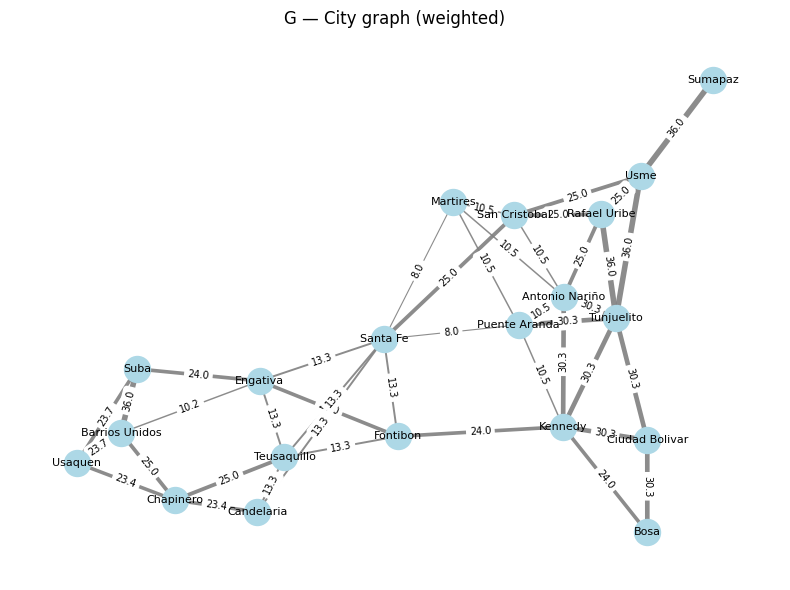

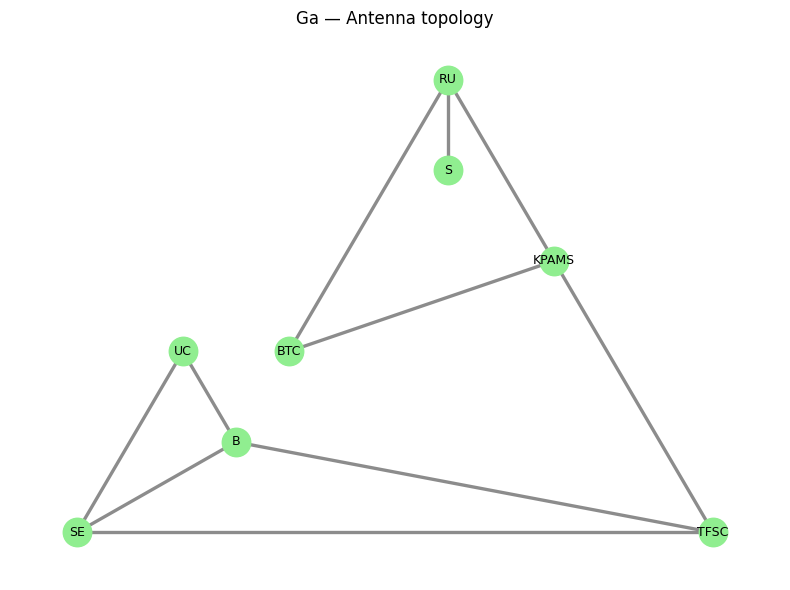

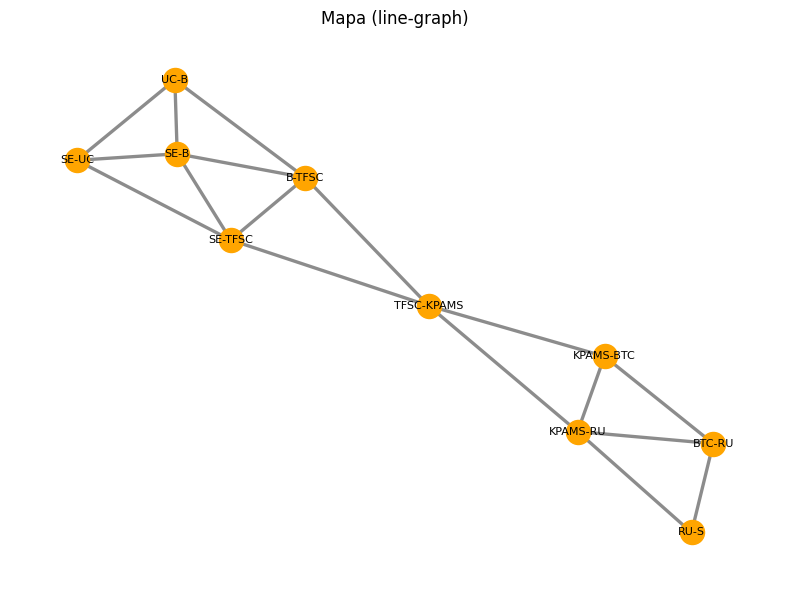

In [ ]:
from ev_model import graphs, simulation, utils, entities, viz
import networkx as nx
import matplotlib.pyplot as plt

print('ev_model modules loaded')
# --- Parameters ---
# You can edit the following lists to change the graphs used by the notebook.

NODES = [
    'Suba', 'Usaquen', 'Chapinero', 'Candelaria', 'Barrios Unidos',
    'Engativa', 'Fontibon', 'Teusaquillo', 'Martires', 'Santa Fe',
    'Usme', 'San Cristobal', 'Antonio Nariño', 'Puente Aranda',
    'Kennedy', 'Bosa', 'Rafael Uribe', 'Tunjuelito', 'Ciudad Bolivar',
    'Sumapaz'
]
# edges: tuples (u, v, weight)
EDGES = [
    ('Suba', 'Usaquen', 23.7), # autonorte
    ('Barrios Unidos', 'Usaquen', 23.7), # autonorte
    ('Usaquen', 'Chapinero', 23.4), # 7ma
    ('Chapinero', 'Candelaria', 23.4), # 7ma
    ('Chapinero', 'Barrios Unidos', 25), # Caracas
    ('Chapinero', 'Teusaquillo', 25), # Caracas
    ('Santa Fe', 'San Cristobal', 25), # Caracas
    ('San Cristobal', 'Rafael Uribe', 25), # Caracas
    ('San Cristobal', 'Usme', 25), # Caracas
    ('Usme', 'Rafael Uribe', 25), # Caracas
    ('Antonio Nariño', 'Rafael Uribe', 25), # Caracas
    ('Santa Fe', 'Martires', 8), # Americas
    ('Santa Fe', 'Puente Aranda', 8), # Americas
    ('Engativa', 'Barrios Unidos', 10.2), # ac 80
    ('Engativa', 'Teusaquillo', 13.3), # ac 26
    ('Candelaria', 'Teusaquillo', 13.3), # ac 26
    ('Santa Fe', 'Teusaquillo', 13.3), # ac 26
    ('Candelaria', 'Santa Fe', 13.3), # ac 26
    ('Engativa', 'Santa Fe', 13.3), # ac 26
    ('Fontibon', 'Santa Fe', 13.3), # ac 26
    ('Fontibon', 'Teusaquillo', 13.3), # ac 26
    ('Suba', 'Barrios Unidos', 36), # av Boyaca
    ('Usme', 'Sumapaz', 36), # av Boyaca
    ('Rafael Uribe', 'Tunjuelito', 36), # av Boyaca
    ('Usme', 'Tunjuelito', 36), # av Boyoca
    ('Suba', 'Engativa', 24), # av cali
    ('Fontibon', 'Engativa', 24), # av cali
    ('Fontibon', 'Kennedy', 24), # av cali
    ('Kennedy', 'Bosa', 24), # av cali
    ('Puente Aranda', 'Kennedy', 10.5), # av 1ra de mayo
    ('Puente Aranda', 'Antonio Nariño', 10.5), # av 1ra de mayo
    ('Puente Aranda', 'Martires', 10.5), # av 1ra de mayo
    ('Antonio Nariño', 'San Cristobal', 10.5), # av 1ra de mayo
    ('Martires', 'San Cristobal', 10.5), # av 1ra de mayo
    ('Martires', 'Antonio Nariño', 10.5), # av 1ra de mayo
    ('Kennedy', 'Tunjuelito', 30.3), # autosur
    ('Kennedy', 'Ciudad Bolivar', 30.3), # autosur
    ('Bosa', 'Ciudad Bolivar', 30.3), # autosur
    ('Tunjuelito', 'Ciudad Bolivar', 30.3), # autosur
    ('Tunjuelito', 'Antonio Nariño', 30.3), # autosur
    ('Tunjuelito', 'Puente Aranda', 30.3), # autosur
    ('Kennedy', 'Antonio Nariño', 30.3) # autosur
]
# Build G from the notebook-specified lists
G = nx.Graph()
G.add_nodes_from(NODES)
G.add_weighted_edges_from(EDGES)

# Aggregated graph (Ga) parameters - also editable in the notebook
GA_NODES = ['SE','UC','B','TFSC','KPAMS','BTC','RU','S']
GA_EDGES = [('SE','TFSC'),('SE','UC'),('TFSC','KPAMS'),('KPAMS','BTC'),('KPAMS','RU'),('BTC','RU'),('RU','S'),('B','SE'),('B','TFSC'),('B','UC')]
GA_DEFAULT_WEIGHT = 1.0
Ga = nx.Graph()
Ga.add_nodes_from(GA_NODES)
Ga.add_edges_from(GA_EDGES)
for u,v in Ga.edges():
    Ga[u][v]['weight'] = GA_DEFAULT_WEIGHT

mapa = graphs.build_mapa(Ga)

viz.draw_graph(G, layout='spring', show_edge_weights=True, weight_attr='weight', scale_width=(0.8, 4.0),
               node_color='lightblue', node_size=350, font_size=8, seed=42, title='G — City graph (weighted)')

viz.draw_graph(Ga, layout='planar', show_edge_weights=False, node_color='lightgreen', node_size=420,
               font_size=9, seed=24, title='Ga — Antenna topology')

# Optionally: visualize the mapa (line-graph) if available
if 'mapa' in globals():
    try:
        from ev_model import viz
    except Exception as e:
        print("Could not import ev_model.viz:", e)
    else:
        viz.draw_graph(mapa, layout='spring', node_color='orange', node_size=300, title='Mapa (line-graph)')

Saved single results CSV to: outputs\results_routes.csv


,placa,ubicacion,nearest_antena,dist_to_antena,dijkstra_route,aoc_time,dijkstra_time
0,car0,Kennedy,KPAMS,18.5,"[Kennedy, Puente Aranda, Santa Fe]",0.000530,0.000511
1,car1,San Cristobal,KPAMS,18.5,"[San Cristobal, Martires, Santa Fe]",0.000428,0.000109
2,car2,Engativa,TFSC,13.3,"[Engativa, Teusaquillo]",0.000217,0.000094
3,car3,San Cristobal,KPAMS,18.5,"[San Cristobal, Martires, Santa Fe]",0.000430,0.000101
4,car4,San Cristobal,KPAMS,18.5,"[San Cristobal, Martires, Santa Fe]",0.000396,0.000100
...,...,...,...,...,...,...,...
995,car995,Candelaria,TFSC,13.3,"[Candelaria, Teusaquillo]",0.000177,0.000081
996,car996,Kennedy,KPAMS,18.5,"[Kennedy, Puente Aranda, Santa Fe]",0.000559,0.000100
997,car997,Antonio Nariño,KPAMS,18.5,"[Antonio Nariño, Martires, Santa Fe]",0.000502,0.000103
998,car998,Barrios Unidos,TFSC,23.5,"[Barrios Unidos, Engativa, Teusaquillo]",0.000196,0.000090


ipywidgets not available: showing the first static visualization.


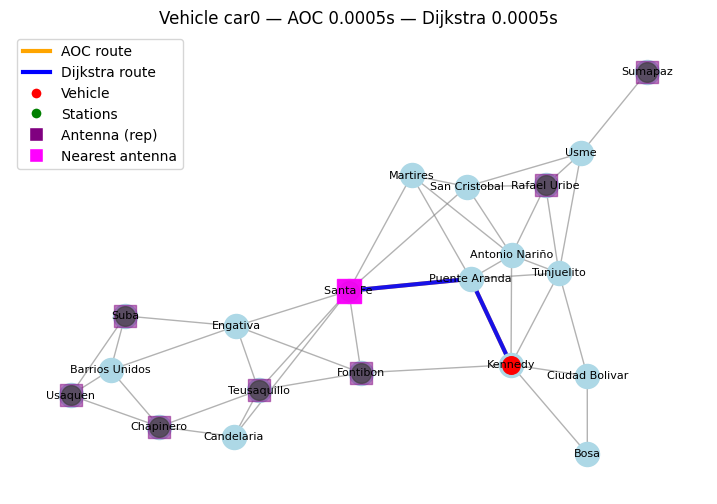

In [ ]:
# Experiment: compute AOC and Dijkstra routes, measure times and visualize per-vehicle with a slider
from ev_model import simulation, viz
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import time
try:
    import ipywidgets as widgets
    from IPython.display import display, clear_output
    WIDGETS_AVAILABLE = True
except Exception:
    WIDGETS_AVAILABLE = False

# Experiment parameters
n = 1000  # number of vehicles
seed = 123
n_trials = 50  # AOC trials

ubicaciones = {
    'SE': ('Suba',),
    'UC': ('Usaquen',),
    'B': ('Chapinero',),
    'TFSC': ('Teusaquillo',),
    'KPAMS': ('Santa Fe',),
    'BTC': ('Fontibon',),
    'RU': ('Rafael Uribe',),
    'S': ('Sumapaz',),
}

# Run the simulation without computing routes (we compute routes here to measure timings)
res = simulation.run_example(n=n, G=G, Ga=Ga, ubicaciones=ubicaciones, random_seed=seed, compute_routes=False)
flota = res['flota'].total
estaciones = res['estaciones']
G = res['G']

# Collect routes and timings per vehicle
rows = []
for auto in flota:
    placa = auto.placa
    ubic = auto.ubicacion
    bateria = auto.bateria

    # AOC (measure time)
    t0 = time.perf_counter()
    try:
        aoc_route = auto.AOC(n_trials, estaciones, G=G)
    except Exception:
        aoc_route = [ubic]
    aoc_time = time.perf_counter() - t0

    # Dijkstra (method supports measure_time)
    try:
        dres = auto.route_dijkstra(estaciones, G=G, measure_time=True)
        if isinstance(dres, tuple):
            dijkstra_route, dijkstra_time = dres
        else:
            dijkstra_route, dijkstra_time = dres, 0.0
    except Exception:
        dijkstra_route, dijkstra_time = [ubic], 0.0

    rows.append({
        'placa': placa,
        'ubicacion': ubic,
        'bateria': bateria,
        'aoc_route': aoc_route,
        'aoc_time': aoc_time,
        'dijkstra_route': dijkstra_route,
        'dijkstra_time': dijkstra_time,
        'aoc_route_len': max(0, len(aoc_route)-1) if isinstance(aoc_route, (list,tuple)) else 0,
        'dijkstra_route_len': max(0, len(dijkstra_route)-1) if isinstance(dijkstra_route, (list,tuple)) else 0,
    })

# Antenna integration: use routing helper to annotate rows
from ev_model.entities import Antenas
from ev_model.routing import integrate_antennas
antenas_obj = Antenas(Ga)
rep_map, rep_to_ga, distances, paths = integrate_antennas(rows, G, antenas_obj, ubicaciones)

import os
os.makedirs('outputs', exist_ok=True)
df = pd.DataFrame(rows)
csv_path = os.path.join('outputs', 'results_routes.csv')
df.to_csv(csv_path, index=False)
print(f'Saved single results CSV to: {csv_path}')
display(df[[ 'placa','ubicacion','nearest_antena','dist_to_antena','dijkstra_route','aoc_time','dijkstra_time' ]])

# Prepare positions for drawing (use helper in ev_model.viz)
pos = viz.get_positions(G, seed=42)

# Display using helpers in ev_model.viz
if WIDGETS_AVAILABLE and len(rows) > 0:
    slider = widgets.IntSlider(min=0, max=len(rows)-1, step=1, value=0, description='Vehicle')
    out = widgets.interactive_output(lambda idx: viz.draw_vehicle_by_index(G, rows, estaciones, rep_map, rep_to_ga, idx, pos), {'idx': slider})
    display(widgets.HBox([slider]))
    display(out)
else:
    print('ipywidgets not available: showing the first static visualization.')
    viz.draw_vehicle_by_index(G, rows, estaciones, rep_map, rep_to_ga, 0, pos)

In [ ]:
# Análisis: centralities, service areas y estructuras críticas
from ev_model import analysis
from IPython.display import display
import os
import pandas as pd
import matplotlib.pyplot as plt

os.makedirs('outputs/analysis', exist_ok=True)

if 'G' not in globals():
    print('Graph `G` not found in the notebook namespace. Ejecuta la celda de construcción de grafos antes de ejecutar este análisis.')
else:
    # 1) Centralities
    try:
        centrals = analysis.compute_centralities(G)
        df_c = analysis.centralities_to_dataframe(centrals)
        df_c.to_csv('outputs/analysis/centralities.csv', index=False)
        print('Saved centralities to outputs/analysis/centralities.csv')
        display(df_c.sort_values(by='betweenness', ascending=False).head(10))
    except Exception as e:
        print('Error computing centralities:', e)

    # 2) Service areas (nearest antenna)
    try:
        if 'rep_map' in globals():
            distances, paths, nearest_map = analysis.service_areas(G, rep_map)
            df_sa = pd.DataFrame([
                {'node': n, 'nearest_antena': nearest_map.get(n), 'dist_to_antena': distances.get(n, float('inf'))}
                for n in G.nodes()
            ])
            df_sa.to_csv('outputs/analysis/service_areas.csv', index=False)
            print('Saved service areas to outputs/analysis/service_areas.csv')
            display(df_sa.head(10))
        else:
            print('`rep_map` no está en el espacio de nombres. Ejecuta la celda del experimento (o integracion de antenas) primero para calcular áreas de servicio.')
    except Exception as e:
        print('Error computing service areas:', e)

    # 3) Critical structures (articulation points y bridges)
    try:
        crit = analysis.critical_structures(G)
        pd.DataFrame({'articulation_point': list(crit.get('articulation_points', []))}).to_csv('outputs/analysis/articulation_points.csv', index=False)
        pd.DataFrame(list(crit.get('bridges', [])), columns=['u', 'v']).to_csv('outputs/analysis/bridges.csv', index=False)
        print('Saved critical structures to outputs/analysis/')
        print(f"Articulation points: {len(crit.get('articulation_points', []))}, Bridges: {len(list(crit.get('bridges', [])))}")
    except Exception as e:
        print('Error computing critical structures:', e)

    # Optional: plot betweenness distribution
    try:
        vals = list(centrals.get('betweenness', {}).values()) if isinstance(centrals, dict) else []
        if vals:
            plt.figure(figsize=(6,3))
            plt.hist(vals, bins=20)
            plt.title('Betweenness centrality distribution')
            plt.xlabel('betweenness')
            plt.ylabel('count')
            plt.tight_layout()
            plt.show()
    except Exception as e:
        print('Could not plot betweenness distribution:', e)
